# Importing the Libraries

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import joblib

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


In [5]:
#Plot style 

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

# Load the Dataset

In [3]:
df = pd.read_csv("Mall_Customers.csv")

# Quick EDA

In [4]:
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [6]:
df.shape

(200, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [9]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [8]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,200.0,NaN,NaN,NaN,100.5,57.879185,1.0,50.75,100.5,150.25,200.0
Gender,200,2,Female,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,200.0,NaN,NaN,NaN,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Annual Income (k$),200.0,NaN,NaN,NaN,60.56,26.264721,15.0,41.5,61.5,78.0,137.0
Spending Score (1-100),200.0,NaN,NaN,NaN,50.2,25.823522,1.0,34.75,50.0,73.0,99.0


# Clean and Prepare Data

In [10]:
df = df.copy()

In [12]:
# Columns like 'CustomerID' that are identifiers, Drop them for Clustering

id_cols = [c for c in df.columns if c.lower().startswith('customer')]
for c in id_cols:
    df.drop(columns=c, inplace=True, errors='ignore')

In [14]:
df.rename(columns={'Annual Income (k$)':'AnnualIncome', 'Spending Score (1-100)':'SpendingScore'}, inplace=True)

In [15]:
df

,Gender,Age,AnnualIncome,SpendingScore
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


In [16]:
df.drop_duplicates(inplace=True)

In [18]:
# Encode 'Gender' column to numeric
if 'Gender' in df.columns:
    df['Gender'] = df['Gender'].astype(str).str.strip().map({'Male':1, 'Female':0})

In [19]:
# Fill missing numeric values(if any) with median 

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    if df[c].isnull().any():
        df[c].fillna(df[c].median(), inplace=True)

In [20]:
print("Columns used for Clustering:", df.columns.tolist())

Columns used for Clustering: ['Gender', 'Age', 'AnnualIncome', 'SpendingScore']


# Feature Selection

In [21]:
use_features = []

if 'AnnualIncome' in df.columns and 'SpendingScore' in df.columns:
    use_features = ['AnnualIncome', 'SpendingScore']
else:
    use_features = [c for c in df.columns if c not in id_cols]

In [24]:
if 'Age' in df.columns:
    use_features.insert(0, 'Age')

In [26]:
print('Selected Features for clustering:', use_features)

Selected Features for clustering: ['Age', 'AnnualIncome', 'SpendingScore']


In [27]:
X = df[use_features].copy()

# Feature Scaling

In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
inertia = []
sil_scores = []
k_range = range(2, 11)

In [36]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot the Elbow Curve

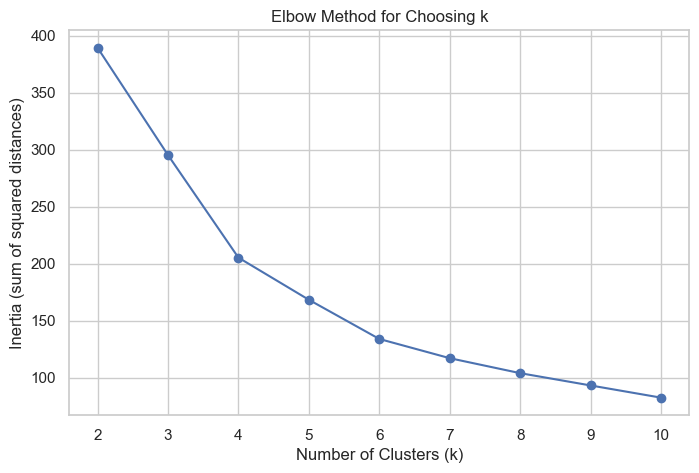

In [37]:
plt.figure()
plt.plot(list(k_range), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (sum of squared distances)')
plt.title('Elbow Method for Choosing k')
plt.xticks(list(k_range))
plt.show()

# Plot Silhouette Scores

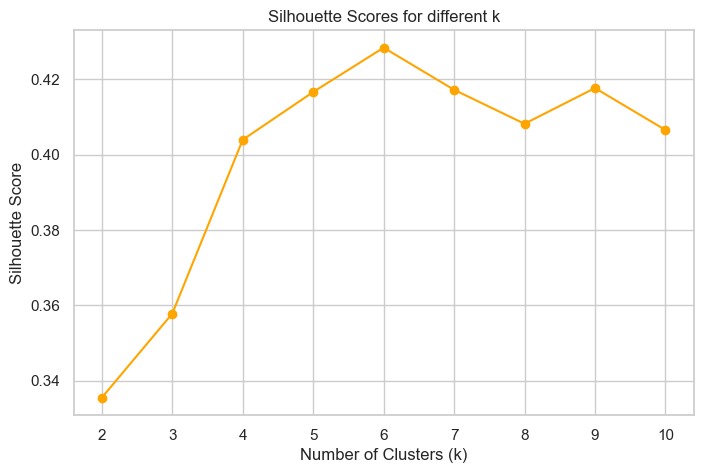

In [38]:
plt.figure()
plt.plot(list(k_range), sil_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for different k')
plt.xticks(list(k_range))
plt.show()

In [39]:
best_k = int(k_range[np.argmax(sil_scores)])
print(f"Best k by silhouette score = {best_k} (silhouette={max(sil_scores):.3f})")

Best k by silhouette score = 6 (silhouette=0.428)


# Train Final KMeans

In [40]:
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=50)
cluster_labels = kmeans_final.fit_predict(X_scaled)
df['Cluster'] = cluster_labels

In [41]:
print('Cluster counts:')
display(df['Cluster'].value_counts().sort_index())

Cluster counts:


Cluster
0    33
1    45
2    24
3    39
4    38
5    21
Name: count, dtype: int64

# Visualize Clusters (PCA 2D)

In [44]:
pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X_scaled)
df['PCA1'] = components[:, 0]
df['PCA2'] = components[:, 1]

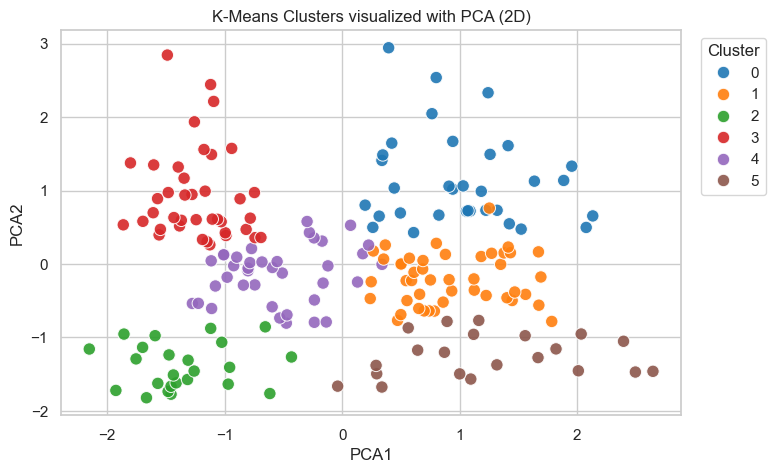

In [45]:
plt.figure()
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=80, alpha=0.9)
plt.title('K-Means Clusters visualized with PCA (2D)')
plt.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

# Cluster Profiling (Business Insights)

In [47]:
profile = df.groupby('Cluster')[use_features].agg(['count', 'mean', 'median', 'std']).round(2)
print('Cluster Profiling (count, mean, median, std):')
display(profile)

Cluster Profiling (count, mean, median, std):


Age                      AnnualIncome                       \
        count   mean median    std        count   mean median    std   
Cluster                                                                
0          33  41.94   43.0  10.18           33  88.94   86.0  16.59   
1          45  56.33   54.0   8.45           45  54.27   54.0   8.98   
2          24  25.25   23.5   5.33           24  25.83   24.5   8.06   
3          39  32.69   32.0   3.73           39  86.54   79.0  16.31   
4          38  26.68   26.0   7.12           38  57.58   60.0   9.85   
5          21  45.52   46.0  11.77           21  26.29   25.0   7.44   

        SpendingScore                       
                count   mean median    std  
Cluster                                     
0                  33  16.97   16.0   9.96  
1                  45  49.07   49.0   6.30  
2                  24  76.92   76.5  13.42  
3                  39  82.13   83.0   9.36  
4                  38  47.79   49.5   9.87  
5                  21  19.38   15.0  12.56

# Compute size and percent

In [48]:
summary = df.groupby('Cluster').agg(size=('Cluster', 'count')).reset_index()
summary['percent'] = (summary['size']/len(df) * 100).round(2)
print('Cluster size Summary:')
display(summary.sort_values('Cluster').reset_index(drop=True))

Cluster size Summary:


,Cluster,size,percent
0,0,33,16.5
1,1,45,22.5
2,2,24,12.0
3,3,39,19.5
4,4,38,19.0
5,5,21,10.5


# Save a Readable Cluster Summary

In [49]:
cluster_means = df.groupby('Cluster')[use_features].mean().round(2)
cluster_means['size'] = df.groupby('Cluster').size()
display(cluster_means)

,Age,AnnualIncome,SpendingScore,size
Cluster,,,,
0,41.94,88.94,16.97,33
1,56.33,54.27,49.07,45
2,25.25,25.83,76.92,24
3,32.69,86.54,82.13,39
4,26.68,57.58,47.79,38
5,45.52,26.29,19.38,21


In [52]:
# Desciriptions (Example)

descriptions = {}
for c in sorted(df['Cluster'].unique()):
    row = cluster_means.loc[c]
    desc = f"Cluster {c}: size={int(row['size'])} | "
    desc += " | ".join([f"{col}={row[col]}" for col in use_features])
    descriptions[c] = desc

In [53]:
print("Suggested Cluster descriptions:")
for c, text in descriptions.items():
    print(text)

Suggested Cluster descriptions:
Cluster 0: size=33 | Age=41.94 | AnnualIncome=88.94 | SpendingScore=16.97
Cluster 1: size=45 | Age=56.33 | AnnualIncome=54.27 | SpendingScore=49.07
Cluster 2: size=24 | Age=25.25 | AnnualIncome=25.83 | SpendingScore=76.92
Cluster 3: size=39 | Age=32.69 | AnnualIncome=86.54 | SpendingScore=82.13
Cluster 4: size=38 | Age=26.68 | AnnualIncome=57.58 | SpendingScore=47.79
Cluster 5: size=21 | Age=45.52 | AnnualIncome=26.29 | SpendingScore=19.38


# Save the Model and Scaler

In [56]:
os.makedirs('model', exist_ok=True)
joblib.dump(kmeans_final, 'model/kmeans_model.pkl')
joblib.dump(scaler, 'model/scaler.pkl')
print('Saved kmeans_model.pkl and scaler.pkl in ./model/')

Saved kmeans_model.pkl and scaler.pkl in ./model/


# Predict function for new customers

In [62]:
def predict_customer_segment(customer_dict):
    """
    customer_dict: dict of {feature_name: value} - keys must match use_features
    Example: {'Annual Income (k$)': 55, 'Spending Score (1-100)': 82}
    """

    x = pd.DataFrame([customer_dict])[use_features]
    x_scaled = scaler.transform(x)
    cluster = kmeans_final.predict(x_scaled)[0]
    return int(cluster)

In [63]:
# Example Usage

example_customer = {}
for f in use_features:
    example_customer[f] = df[f].median()

predicted_cluster = predict_customer_segment(example_customer)
print('Example customer predicted cluster:', predicted_cluster)

Example customer predicted cluster: 4


In [64]:
# Save the Results

df.to_csv('model/customer_segment_labeled.csv', index=False)
cluster_means.to_csv('model/cluster_means.csv')

print('Saved labeled dataset and cluster summary to ./model/')

Saved labeled dataset and cluster summary to ./model/
